# Differential-Drive Controller Design

This notebook computes controller parameters for CT controller to assign closed-loop pole locations. We will also discretize and simulate the CT controllers.

Using @zongyao's open-loop robot dynamics:

$$X(s) = \frac{1}{Ms^2 + Cs} V(s)$$

and an assumed controller structure of:

$$C(s) = \frac{k}{s^2 + As + B}$$

yields a closed-loop TF of:

$$G_{CL}(s) = \frac{C(s)G(s)}{1+C(s)G(s)} = \frac{k}{Ms^4 + (C+AM)s^3 + (AC+BM)s^2 +BCs + k} = \frac{b(s)}{a(s)}$$

Let's match these coefficients to the desired closed-loop structure, i.e.:

$$a_d(s) = \theta (s + \alpha)(s + \beta) (s^2 + \gamma s + \phi)$$

or

$$a_d(s) = \theta(s^4 + (\gamma + \alpha + \beta)s^3 + (\phi + \alpha \beta + \gamma(\alpha + \beta))s^2 + (\phi(\alpha + \beta) + \alpha \beta \gamma)s + \alpha \beta \phi)$$

where $a_d(s)$ is the desired characteristic equation, $\alpha$, $\phi$, and $\gamma$ are design parameters selected according to the following conditions:

$$\sqrt{\phi} = \bar{\omega}_n = 2 \ \text{rad/s}$$

$$\gamma = 2 \bar{\zeta} \omega_n = 2*0.707*2 = 2.83$$

$$\alpha = 10\bar{\omega}_n = 20 \ \text{rad/s}$$

These conditions are selected such that the real poles (the control poles) are fast, and the complex pair (the design poles) follow the second order response dictated by design parameters $\bar{\omega}_n$ and $\bar{\zeta}$.

## Matching Terms

Matching terms in $a_d(s)$ and $a(s)$ gives:

\begin{align}
\theta &= M \\ \\
\theta (\gamma + \alpha + \beta) &= C + AM \\ \\
\theta (\phi + \alpha \beta + \gamma (\alpha + \beta)) &= AC + BM \\ \\
\theta (\phi(\alpha + \beta) + \alpha \beta \gamma) &= BC \\ \\
\theta \alpha \beta \phi &= k
\end{align}

where

\begin{align}
\phi &= 4 \\ \\
\gamma &= 2.83 \\ \\
\alpha &= 20
\end{align}

Rearranging the above equations yields a system of equations:

\begin{equation}
\begin{bmatrix}
1 && 0 && -1 && 0 \\
\frac{C}{M} && 1 && -(\alpha + \gamma) && 0 \\
0 && \frac{C}{M} && -(\alpha \gamma + \phi) && 0 \\
0 && 0 && \alpha \phi && -\frac{1}{M}
\end{bmatrix}
\begin{bmatrix}
A \\
B \\
\beta \\
k
\end{bmatrix}
=
\begin{bmatrix}
-\frac{C}{M} + \gamma \alpha \\
\phi + \alpha \gamma \\
\phi \alpha \\
0
\end{bmatrix}
\end{equation}

In [1]:
%matplotlib inline
import numpy as np
import control
import matplotlib.pyplot as plt

In [2]:
# design parameters
pole_factor = 10
omega_set = 2
zeta_set = 0.707

# system parameters from @zongyao
C = 16.9778
M = 0.1728

# function to compute controller parameters
def controller(pole_factor, omega, zeta, C, M):
    alpha = 10*omega
    gamma = 2*zeta*omega
    phi = omega**2

    # A_mat x = B_mat
    A_mat = np.array([[1, 0, -1, 0],
                      [C/M, 1, -(alpha + gamma), 0],
                      [0, C/M, -(alpha * gamma + phi), 0],
                      [0, 0, alpha * phi, -1/M]])

    B_mat = np.array([-C/M + gamma + alpha, phi + alpha * gamma, 
                      phi * alpha, 0])
    
    # solve system of linear equations
    x, res, _, _ = np.linalg.lstsq(A_mat, B_mat)
    
    # check residuals before returning
    assert (res.tolist() == [])
    return x

In [3]:
# define wrapper function to compute
# controller parameters and plot step response and pzmap

def test_controller(pole_factor, omega_set, zeta_set):
    A, B, _, k = controller(pole_factor, omega_set, zeta_set, C, M)

    # enter controller as a tf
    c_sys = control.tf([k],[1, A, B])

    # CL system as tf
    sys_cl = control.tf([k], 
                        [M, (C + A * M), (A * C + B * M), B * C, k])

    print('Controller is: \n')
    print(c_sys)

    print('Closed-loop system is: \n')
    print(sys_cl)
    
    control.pzmap.pzmap(sys_cl)
    
    y, t = control.step(sys_cl)
    plt.figure()
    plt.plot(t, y)
    
    return k, A, B, sys_cl

# Discretization using Tustin's Method

Discretizing the generic controller using Tustin's method gives:

$$C(s) = \frac{k}{s^2 + As + B}$$

$$s = \frac{2}{T} \frac{z-1}{z+1}$$

$$C(z) = \frac{k}{ \left( \frac{2}{T} \frac{z-1}{z+1} \right)^2 + A \left( \frac{2}{T} \frac{z-1}{z+1} \right) + B}$$

$$ = \frac{k(z+1)^2}{\frac{4}{T^2} (z-1)^2 + \frac{2A}{T}(z-1)(z+1) + B(z+1)^2 }$$

$$ = \frac{k + 2k z^{-1} + k z^{-2}}{ \left( \frac{4}{T^2} + \frac{2A}{T} + B \right) + \left( 2B - \frac{8}{T^2} \right) z^{-1} + \left( \frac{4}{T^2} - \frac{2A}{T} + B \right) }$$

which yields the difference equation:

$$ u[k] = \frac{1}{a_1} \left[ -a_2 u[k-1] - a_3 u[k-2] + b_1 e[k] + b_2 e[k-1] + b_3 e[k-2] \right] $$

where

\begin{align}
a_1 &= \frac{4}{T^2} + \frac{2A}{T} + B \\
a_2 &= 2B - \frac{8}{T^2} \\
a_3 &= \frac{4}{T^2} - \frac{2A}{T} + B \\
b_1 &= K \\
b_2 &= 2K \\
b_3 &= K
\end{align}

In [4]:
# set sample period
def tustin(k, A, B, T):
    a1 = (4.0 / T**2) + (2.0 * A / T) + B
    a2 = 2.0 * B - (8 / (T**2))
    a3 = (4.0 / (T**2.0)) - (2.0 * A / T) + B
    b1 = k
    b2 = 2.0*k
    b3 = k
    print('u[k] = %+.4f u[k-1] %+.4f u[k-2] %+.4f e[k] %+.4f e[k-1]'
          '%+.4f e[k-2]' % (-(a2 / a1), -(a3 / a1), (b1 / a1), (b2 / a1),
                            (b3 / a1)))
    print('num: [%+.4f, %+.4f, %+.4f]\n den: '
          '[%+.4f, %+.4f, %+.4f]' % (b1, b2, b3, a1, a2, a3))

# Trial 1 - Critically Damped

Determine controllers for each experimental trial.

Trial 1: $\zeta$ = 1, $\omega_n$ = 2 rad/s

Controller is: 


        1358
--------------------
s^2 + 23.99 s + 84.8

Closed-loop system is: 


                       1358
--------------------------------------------------
0.1728 s^4 + 21.12 s^3 + 421.9 s^2 + 1440 s + 1358



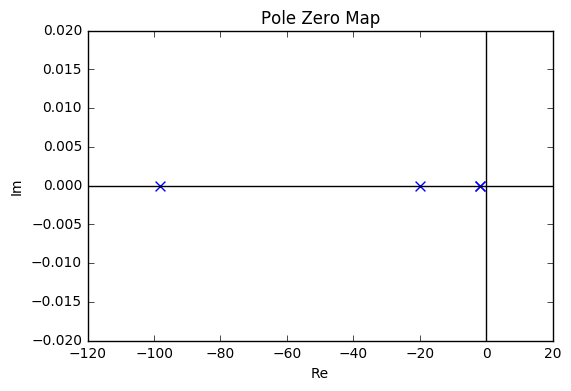

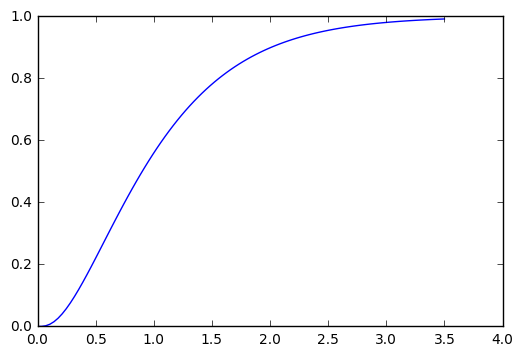

In [5]:
k1, A1, B1, sys1 = test_controller(10, 2, 1)

In [6]:
tustin(k1, A1, B1, 0.01)

u[k] = +1.7786 u[k-1] -0.7862 u[k-2] +0.0303 e[k] +0.0605 e[k-1]+0.0303 e[k-2]
num: [+1358.0741, +2716.1483, +1358.0741]
 den: [+44882.6367, -79830.3901, +35286.9732]


# Trial 2 - Low Damping

Trial 2: $\zeta$ = 0.3, $\omega_n$ = 2 rad/s

Controller is: 


         1358
---------------------
s^2 + 21.19 s + 28.81

Closed-loop system is: 


                        1358
---------------------------------------------------
0.1728 s^4 + 20.64 s^3 + 364.7 s^2 + 489.2 s + 1358



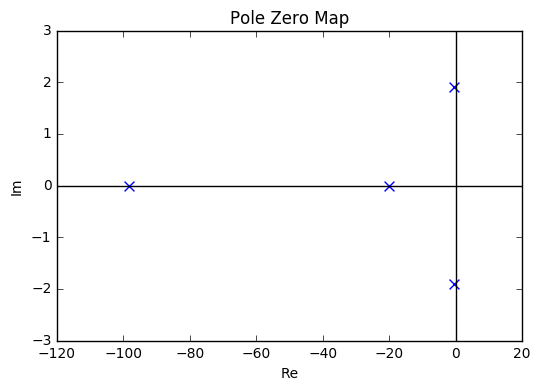

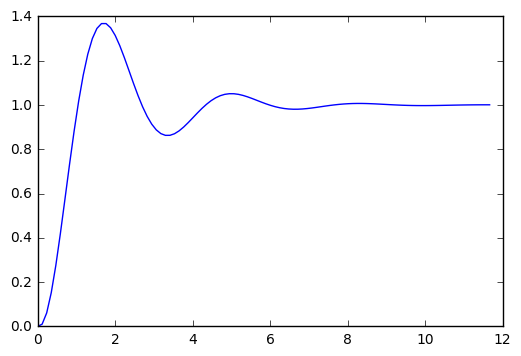

In [7]:
k2, A2, B2, sys2 = test_controller(10, 2, 0.3)

In [8]:
tustin(k2, A2, B2, 0.01)

u[k] = +1.8059 u[k-1] -0.8085 u[k-2] +0.0307 e[k] +0.0614 e[k-1]+0.0307 e[k-2]
num: [+1358.0785, +2716.1569, +1358.0785]
 den: [+44266.7055, -79942.3775, +35790.9170]


# Trial 3 - Non-resonating Damping

Trial 3: $\zeta$ = 0.707, $\omega_n$ = 2 rad/s

Controller is: 


         1358
---------------------
s^2 + 22.82 s + 61.37

Closed-loop system is: 


                      1358
------------------------------------------------
0.1728 s^4 + 20.92 s^3 + 398 s^2 + 1042 s + 1358



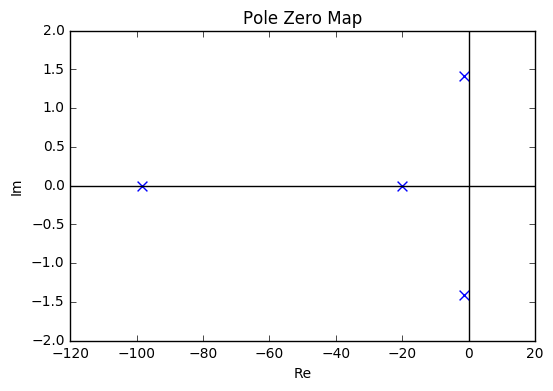

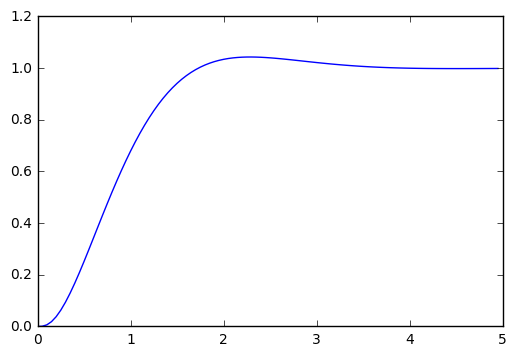

In [9]:
k3, A3, B3, sys3 = test_controller(10, 2, 0.707)

In [10]:
tustin(k3, A3, B3, 0.01)

u[k] = +1.7900 u[k-1] -0.7955 u[k-2] +0.0304 e[k] +0.0609 e[k-1]+0.0304 e[k-2]
num: [+1358.0760, +2716.1519, +1358.0760]
 den: [+44624.8260, -79877.2647, +35497.9093]


# Trial 4 - Mid Rise Time

Trial 3: $\zeta$ = 0.707, $\omega_n$ = 4 rad/s

Controller is: 


      1.085e+04
---------------------
s^2 + 45.54 s + 248.5

Closed-loop system is: 


                       1.085e+04
-------------------------------------------------------
0.1728 s^4 + 24.85 s^3 + 816.1 s^2 + 4218 s + 1.085e+04



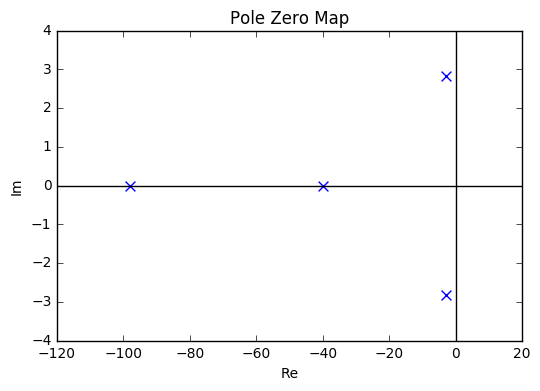

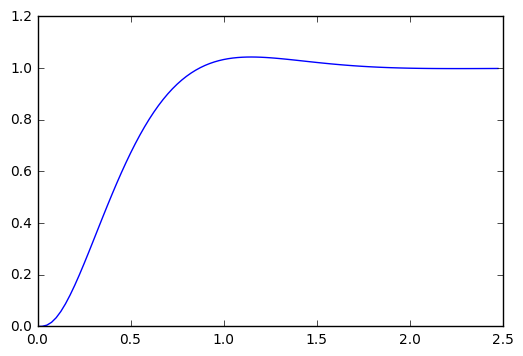

In [11]:
k4, A4, B4, sys4 = test_controller(10, 4, 0.707)

In [12]:
tustin(k4, A4, B4, 0.01)

u[k] = +1.6108 u[k-1] -0.6309 u[k-2] +0.2199 e[k] +0.4398 e[k-1]+0.2199 e[k-2]
num: [+10852.7085, +21705.4170, +10852.7085]
 den: [+49356.0014, -79503.0755, +31140.9231]


# Trial 5 - Fast Rise Time

Trial 5: $\zeta$ = 0.707, $\omega_n$ = 7 rad/s

Controller is: 


      5.744e+04
---------------------
s^2 + 78.55 s + 766.6

Closed-loop system is: 


                         5.744e+04
-----------------------------------------------------------
0.1728 s^4 + 30.55 s^3 + 1466 s^2 + 1.302e+04 s + 5.744e+04



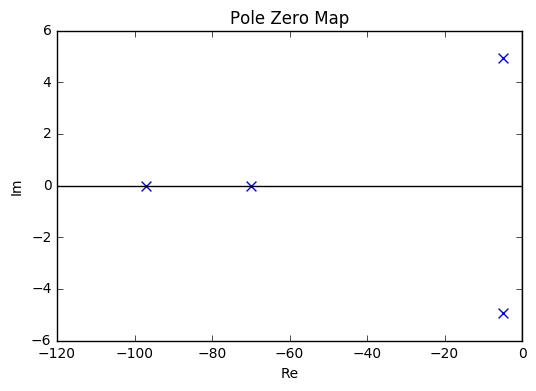

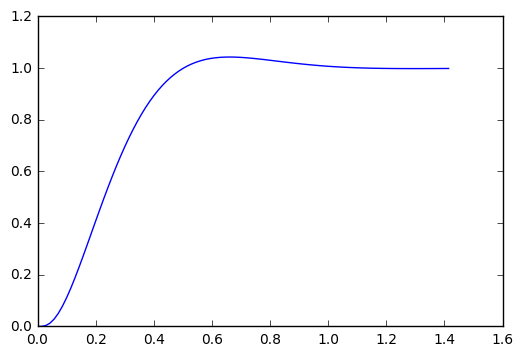

In [13]:
k5, A5, B5, sys5 = test_controller(10, 7, 0.707)

In [14]:
tustin(k5, A5, B5, 0.01)

u[k] = +1.3894 u[k-1] -0.4437 u[k-2] +1.0170 e[k] +2.0339 e[k-1]+1.0170 e[k-2]
num: [+57435.0675, +114870.1350, +57435.0675]
 den: [+56476.6548, -78466.8109, +25056.5343]


In [15]:
t = np.linspace(0, 10, 10000)
y1, t1 = control.step(sys1, t)
y2, t2 = control.step(sys2, t)
y3, t3 = control.step(sys3, t)
y4, t4 = control.step(sys4, t)
y5, t5 = control.step(sys5, t)

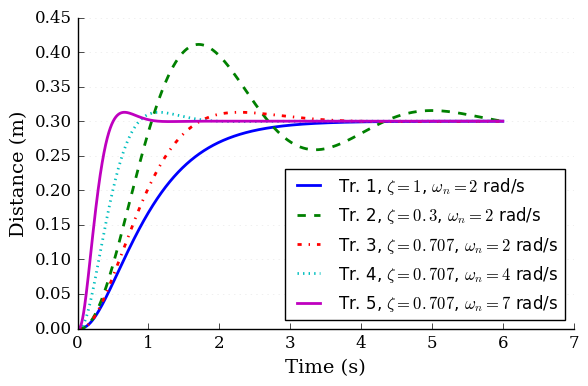

In [16]:
fig = plt.figure(figsize=(6, 4))
ax = plt.gca()

# Change the axis units to serif
plt.setp(ax.get_ymajorticklabels(), family='serif', fontsize=12)
plt.setp(ax.get_xmajorticklabels(), family='serif', fontsize=12)

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# Turn on a horizontal grid and set appropriate linestyle and color
ax.yaxis.grid(True, linestyle=':', which='major', color='lightgrey',
               alpha=0.5)
ax.set_axisbelow(True)

# plt.title('Step Response with Varying Damping', family='Serif')
plt.ylabel('Distance (m)', family='Serif', fontsize=14)
plt.xlabel('Time (s)', family='Serif', fontsize=14)

# # Linear sim, so we can just scale the output for a step input of 30 cm
# plt.plot(t1, (y1 / 3.33333333), ls='-', lw=2, 
#          label=r'Tr. 1,$\zeta = 1$, $\omega_n = 2$ rad/s')
# plt.plot(t2, (y2 / 3.33333333), ls='-', lw=2, 
#          label=r'Tr. 2, $\zeta = 0.3$, $\omega_n = 2$ rad/s')
# plt.plot(t3, (y3 / 3.33333333), ls='-', lw=2, 
#          label=r'Tr. 3, $\zeta = 0.707$, $\omega_n = 2$ rad/s')
# plt.plot(t4, (y4 / 3.33333333), ls='-', lw=2, 
#          label=r'Tr. 4, $\zeta = 0.707$, $\omega_n = 4$ rad/s')
# plt.plot(t5, (y5 / 3.33333333), ls='-', lw=2, 
#          label=r'Tr. 5, $\zeta = 0.707$, $\omega_n = 7$ rad/s')

plt.plot(t1[:6001], (y1[:6001] / 3.33333333), ls='-', lw=2, 
         label=r'Tr. 1, $\zeta = 1$, $\omega_n = 2$ rad/s')
plt.plot(t2[:6001], (y2[:6001] / 3.33333333), ls='--', lw=2, 
         label=r'Tr. 2, $\zeta = 0.3$, $\omega_n = 2$ rad/s')
plt.plot(t3[:6001], (y3[:6001] / 3.33333333), ls='-.', lw=2, 
         label=r'Tr. 3, $\zeta = 0.707$, $\omega_n = 2$ rad/s')
plt.plot(t4[:6001], (y4[:6001] / 3.33333333), ls=':', lw=2, 
         label=r'Tr. 4, $\zeta = 0.707$, $\omega_n = 4$ rad/s')
plt.plot(t5[:6001], (y5[:6001] / 3.33333333), ls='-', lw=2, 
         label=r'Tr. 5, $\zeta = 0.707$, $\omega_n = 7$ rad/s')

plt.legend(loc='lower right')

plt.tight_layout()
plt.savefig('step_results.pdf', dpi=600)
plt.show()